In [3]:
#
# Example of fitting A->B->C where measurements are for A and B/B+C
#

In [4]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [7]:
filename = '/home/paperspace/learn_kipet/my_data_sets/ABC_data.csv'
D_frame = read_file(filename)

read dir : /home/paperspace/learn_kipet/my_data_sets/ABC_data.csv


In [8]:
D_frame.shape

(20, 3)

In [9]:
D_frame.columns = ['A', 'B', 'C']
D_frame

,A,B,C
t,,,
0.000,0.957,-0.031,-0.015
0.263,0.557,0.330,0.044
0.526,0.342,0.512,0.156
0.789,0.224,0.499,0.310
1.053,0.123,0.428,0.454
1.316,0.079,0.396,0.556
1.579,0.035,0.303,0.651
1.842,0.029,0.287,0.658
2.105,0.025,0.221,0.750


In [12]:
C_frame = D_frame['A']
Y_frame = D_frame.copy()
Y_frame['y'] = D_frame['B'] / (D_frame['B'] + D_frame['C'])
Y_frame = Y_frame['y']

In [14]:
builder = TemplateBuilder()    
components = {'A':1,'B':0,'C':0}
builder.add_mixture_component(components)
builder.add_algebraic_variable('y', init = 0.0, bounds = (0.0, 1.0))
builder.add_parameter('k1',initialize = 5.0, bounds=(0.0,10.0))
builder.add_parameter('k2',initialize = 5.0, bounds=(0.0,10.0))
builder.add_concentration_data(C_frame)

Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted


In [15]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t, 'y'] * (m.Z[t, 'B'] + m.Z[t, 'C']) - m.Z[t, 'B'])
    return r

builder.set_odes_rule(rule_odes)
builder.set_algebraics_rule(rule_algebraics)

opt_model = builder.create_pyomo_model(0.0,5.0)

In [18]:
#sigmas = {'A':1e-10,'B':1e-11,'C':1e-8}
sigmas = {'A':1, 'B':1, 'C':1}
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=50,ncp=3,scheme='LAGRANGE-RADAU')

In [22]:
options = dict()
results_pyomo = p_estimator.run_opt('ipopt',
                                    variances=sigmas,
                                  tee=True,
                                  solver_opts = options,
                                  covariance=False)

Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     4356
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      622

Total number of variables............................:     1056
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       22
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1054
Total number of inequali

In [23]:
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 2.025449629072174
k2 0.3413462144334731


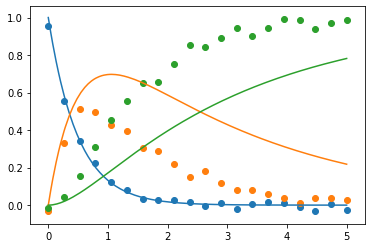

In [24]:
fig, ax = plt.subplots()
for c in ['A', 'B', 'C']:
    ax.scatter(D_frame.index, D_frame[c])
    ax.plot(results_pyomo.Z.index, results_pyomo.Z[c])